# **Analyzing Weather Patterns and Predicting Weather Metrics in Valencia, Spain and Nearby Regions**

Tenzin Lhamo

# Introduction


Valencia, Spain is located around the Eastern coastline of Spain, known around the world for its Mediterranean charm. However, over the past few decades, it has become vulnerable to deadly natural disasters like storms and floods. Just this past October of 2024, Spain's Valencia, Castilla-La Mancha, and Andalusia regions experienced one of their deadliest natural disasters in history where torrential rain resulted in flash floods. These floods washed away the people, cars, houses, and roads of the Valencia and nearby regions. As the search for missing people continued for weeks, the death toll grew larger and larger. Ultimately, the floods took the lives of 211 people and left the region with billions in damage (Medrano, 2024). Many people around Spain blame regional governments for not being prepared by sending out warnings to the citizens. The disastrous floodings seem to be caused by a numerous of factors, including location, heavy rain, climate change, and lack of governmental preparation.

The deadly flash floods in Valencia and nearby regions is one of many. Over the past couple of decades, it has become evident that climate change has intensified, leading to record-breaking natural disasters such as earthquakes, forest fires, and torrential rains. As the change becomes more drastic, it becomes crucial to study, find the root cause, and prevent future damages. The objective of this project is to examine seasonal trends in the weather from January 2014 to December 2024 and build predictive models to predict future trends and conditions. This can be helpful in predicting future catastrophic events, mitigating their impacts, and improving overall preparedness of communities.

**Note**: Initially, the focus of the project was on floods and precipitation. However, after doing analyses, there was low correlation and potential data issues with the API. For example, the rainfall measurements were significant lower than other reported measurements. This could be due to limitations or issues in methodology and coverage. Since the precipitation data is crucial in understanding the flood patterns, the focus was shifted to seasonal weather trends and predicting weather metrics.

The questions I will address are:
- What are the seasonal trends in temperature and precipitation in Valencia and nearby regions over the past decade?
- How accurately can daily temperature and humidity levels be predicted using machine learning models?
- What factors contribute most to predicting temperature and humidity?

# Data Collection

The data will be accessed using the Visual Crossing API, which contains historical and forecast weather data. The link to the API website can be found at the references section. For the purposes of this project, the data focuses on the location 'Comunidad Valenciana' which encompasses the autonomous Spanish community/region of Valencia.


**Library Loading**

In [ ]:
#load all libraries
import json
import requests
from datetime import datetime, timedelta
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


**Visual Crossing API Accessing**

In [ ]:
#insert API key and base URL
api_key = '5VGZPHPB3Z5XED5VU2HKKTY34'
base_url = 'https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/comunidad%20valenciana'

#collect data from January 1, 2014 to most recent available data
years = range(2014, 2025)

#store all data in list
all_data = []

#collect data for each month of each year from 2014 to 2024
for year in years:
    for month in range(1, 13):
        start_date = f"{year}-{month:02d}-01"
        if month == 12:
            end_date = f"{year}-12-31"
        else:
            end_date = f"{year}-{month+1:02d}-01"
            end_date = (datetime.strptime(end_date, "%Y-%m-%d") - timedelta(days = 1)).strftime("%Y-%m-%d")

        #create api url
        vc_url = f"{base_url}/{start_date}/{end_date}?unitGroup=metric&key={api_key}&contentType=json"

        #make API request
        vc_r = requests.get(vc_url)

        #check if api request was successful
        if vc_r.status_code == 200:
            print(f"Data retrieved for {start_date} to {end_date}")
            vc_data = vc_r.json()

            #save original data to JSON file
            if len(all_data) == 0:
                with open('visual_crossing_data.json', 'w') as file:
                    json.dump(vc_data, file)

            #check if 'days' key exists with error handling
            if 'days' in vc_data:
                all_data.extend(vc_data['days'])
        else:
            print(f"Error {vc_r.status_code} for {start_date} to {end_date}: {vc_r.text}")

#convert into dataframe
if all_data:
    vc_df = pd.DataFrame(all_data)
    #print columns
    print(vc_df.columns)
else:
    print("No data retrieved.")

#save data to new JSON file
with open('valencia_weather_10_years.json', 'w') as file:
    json.dump(all_data, file)

print(f"Total data points collected: {len(all_data)}")

Data retrieved for 2014-01-01 to 2014-01-31
Data retrieved for 2014-02-01 to 2014-02-28
Data retrieved for 2014-03-01 to 2014-03-31
Data retrieved for 2014-04-01 to 2014-04-30
Data retrieved for 2014-05-01 to 2014-05-31
Data retrieved for 2014-06-01 to 2014-06-30
Data retrieved for 2014-07-01 to 2014-07-31
Data retrieved for 2014-08-01 to 2014-08-31
Data retrieved for 2014-09-01 to 2014-09-30
Data retrieved for 2014-10-01 to 2014-10-31
Data retrieved for 2014-11-01 to 2014-11-30
Data retrieved for 2014-12-01 to 2014-12-31
Data retrieved for 2015-01-01 to 2015-01-31
Data retrieved for 2015-02-01 to 2015-02-28
Data retrieved for 2015-03-01 to 2015-03-31
Data retrieved for 2015-04-01 to 2015-04-30
Data retrieved for 2015-05-01 to 2015-05-31
Data retrieved for 2015-06-01 to 2015-06-30
Data retrieved for 2015-07-01 to 2015-07-31
Data retrieved for 2015-08-01 to 2015-08-31
Data retrieved for 2015-09-01 to 2015-09-30
Data retrieved for 2015-10-01 to 2015-10-31
Data retrieved for 2015-11-01 to

The selected data from the Visual Crossing API covers weather information in Valencia from each month from January 2014 to December 2024. The request library from Python was used to retrieve the data. Some additional steps are taken for error handling of API errors, like checking the request status code, converting 'datetime' to the proper format for Pandas, and checking to see if the 'days' key exists in the data. The dataset is saved to a JSON file called 'valencia_weather_years.json'

**Data Wrangling**

In [ ]:
#convert data to dataframe
if all_data:
    vc_df = pd.DataFrame(all_data)

    #select columns of interest
    columns_of_interest = ['datetime', 'tempmax', 'tempmin', 'temp', 'humidity']
    vc_df = vc_df[columns_of_interest]

    #convert 'datetime' column to proper format for Pandas
    vc_df['datetime'] = pd.to_datetime(vc_df['datetime'])

    #remove missing values
    vc_df = vc_df.dropna()

    #add 'year' and 'month' columns
    vc_df['Year'] = vc_df['datetime'].dt.year
    vc_df['Month'] = vc_df['datetime'].dt.month

    #save clean dataframe to csv file
    vc_df.to_csv('valencia_weather_10_years_clean.csv', index = False)
    print("Data saved to valencia_weather_10_years_clean.csv")

    #print the first few rows
    print(vc_df.head())
else:
    print("No data retrieved")


Data saved to valencia_weather_10_years_clean.csv
    datetime  tempmax  tempmin  temp  humidity  Year  Month
0 2014-01-01     18.3     10.9  14.9      54.2  2014      1
1 2014-01-02     18.8     13.1  16.3      61.9  2014      1
2 2014-01-03     19.9     16.0  18.0      60.3  2014      1
3 2014-01-04     21.8      9.8  16.1      55.3  2014      1
4 2014-01-05     16.0      7.9  11.7      53.3  2014      1


The selected columns of interest from the API are related to temperature and humidity as the concentration is the flash floods. The columns of interest are 'datetime', 'tempmax', 'tempmin', 'temp', and 'humidity'.

- '**datetime**' represents the date and time in the Pandas datetime format
- '**tempmax**' represents maximum temperature in Celcius
- '**tempmin**' represents minimum temperature in Celcius
- '**temp**' represents the mean temperature in Celcius
- '**humidity**' represents relative humidity in percentage
- '**Year**' represents each year from 2014 to 2024
- '**Month**' represents each month from 1 to 12 where 1 corresponds with January, 2 corresponds with February, 3 corresponds with March...

Additionally, missing values are removed. The clean data is saved to a CSV file called 'valencia_weather_10_years_clean.csv'

# Exploratory Data Analysis



In [ ]:
#get first and last few rows
print(vc_df.head())
print(vc_df.tail())

    datetime  tempmax  tempmin  temp  humidity  Year  Month
0 2014-01-01     18.3     10.9  14.9      54.2  2014      1
1 2014-01-02     18.8     13.1  16.3      61.9  2014      1
2 2014-01-03     19.9     16.0  18.0      60.3  2014      1
3 2014-01-04     21.8      9.8  16.1      55.3  2014      1
4 2014-01-05     16.0      7.9  11.7      53.3  2014      1
       datetime  tempmax  tempmin  temp  humidity  Year  Month
4013 2024-12-27      9.5      1.7   4.5      52.5  2024     12
4014 2024-12-28     11.7     -0.3   4.7      51.3  2024     12
4015 2024-12-29     16.6      5.6  10.6      62.5  2024     12
4016 2024-12-30     17.1      5.7  11.0      60.5  2024     12
4017 2024-12-31     17.2      6.2  11.3      62.0  2024     12


In [ ]:
#retrieve number of rows and columns of df
print(vc_df.shape)

(4018, 7)


There are a total of 4018 rows and 7 columns.

In [ ]:
#get summary statistics for columns
print(vc_df.describe())

                            datetime      tempmax      tempmin         temp  \
count                           4018  4018.000000  4018.000000  4018.000000   
mean   2019-07-02 11:59:59.999999744    23.410005    13.564385    18.332802   
min              2014-01-01 00:00:00     6.200000    -1.600000     3.400000   
25%              2016-10-01 06:00:00    18.500000     8.500000    13.200000   
50%              2019-07-02 12:00:00    23.400000    13.400000    18.150000   
75%              2022-04-01 18:00:00    28.500000    19.000000    23.700000   
max              2024-12-31 00:00:00    45.700000    28.500000    32.800000   
std                              NaN     6.016675     6.334155     6.052858   

          humidity         Year        Month  
count  4018.000000  4018.000000  4018.000000  
mean     63.780189  2019.000747     6.522648  
min      23.700000  2014.000000     1.000000  
25%      54.600000  2016.000000     4.000000  
50%      65.000000  2019.000000     7.000000  
75%   

In [ ]:
#check column data types
print(vc_df.dtypes)

datetime    datetime64[ns]
tempmax            float64
tempmin            float64
temp               float64
humidity           float64
Year                 int32
Month                int32
dtype: object


In [ ]:
#double check for missing values
vc_df.isnull().sum()

,0
datetime,0
tempmax,0
tempmin,0
temp,0
humidity,0
Year,0
Month,0


In [ ]:
#summarize temp, humidity, and precip columns
summary = vc_df[['temp', 'humidity', 'tempmax', 'tempmin']].describe()
print(summary)

              temp     humidity      tempmax      tempmin
count  4018.000000  4018.000000  4018.000000  4018.000000
mean     18.332802    63.780189    23.410005    13.564385
std       6.052858    12.917932     6.016675     6.334155
min       3.400000    23.700000     6.200000    -1.600000
25%      13.200000    54.600000    18.500000     8.500000
50%      18.150000    65.000000    23.400000    13.400000
75%      23.700000    72.700000    28.500000    19.000000
max      32.800000    98.700000    45.700000    28.500000


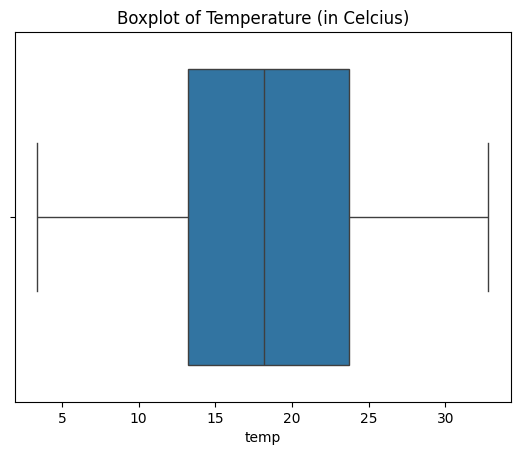

In [ ]:
#create box plot of 'temp'
sns.boxplot(x = vc_df['temp'])
plt.title("Boxplot of Temperature (in Celcius)")
plt.show()

The boxplot of temperature shows that the interquartile range falls from around 13 to 22 degrees Celcius. The median temperature falls around 17 degrees Celcius. The minimum temperature is around 5 degrees Celcius and the maximum temperature is slightly greater than 30 degrees Celcius. There seems to be no outliers.

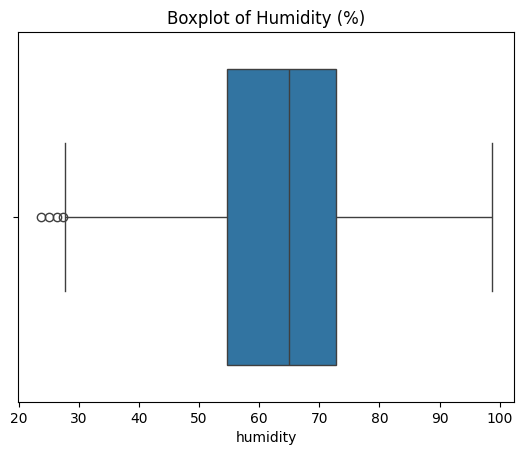

In [ ]:
#create box plot of 'humidity'
sns.boxplot(x = vc_df['humidity'])
plt.title("Boxplot of Humidity (%)")
plt.show()

The boxplot of humidity in percentage shows that the interquartile range falls between 60% and 80%. The minimum humidity percentage is slightly less than 40% and the maximum is slightly less than 100%. There are some outliers that fall below 40%.

# Data Visualization

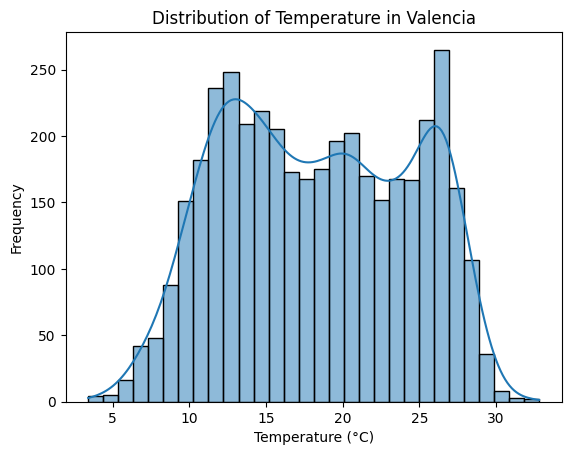

In [ ]:
#create histogram for temperature distribution
sns.histplot(vc_df['temp'], bins = 30, kde = True)
plt.title("Distribution of Temperature in Valencia")
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency')
plt.show()

The histogram features a combined distribution of temperature and kernel density estimate. The highest frequencies occurs at between 10-15 degrees Celcius and between 25-30 degrees Celcius.It seems like the temperature data might have a bimodal distribution and could correspond to the different seasons. The distribution is very slightly skewed to the right. The majority of the temperatures fall between around 5 to 30 degrees Celcius.

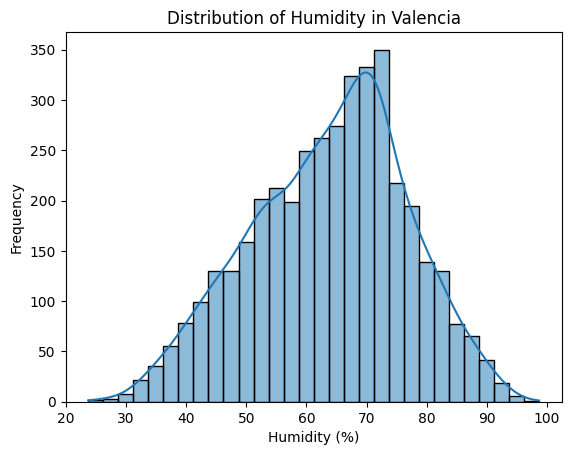

In [ ]:
#create histogram for humidity distribution
sns.histplot(vc_df['humidity'], bins = 30, kde = True)
plt.title("Distribution of Humidity in Valencia")
plt.xlabel('Humidity (%)')
plt.ylabel('Frequency')
plt.show()

The line plot shows the average precipitation and humidity patterns in Valencia organized by months. Precipitation levels tend to be at the highest levels during the fall and early winter months (around October to December). This indicates that Valencia is more prone to floodings around these months. Humidity percentages tend to be highest around the spring (March to April) and fall months (September to November). The humidity levels seems to increase by a noticeable amount around January as well. There seems to be slight correlation with the precipitation and humidity levels.

In [ ]:
#check correlation between temp and humidity
corr_matrix = vc_df[['temp', 'humidity']].corr()
print(corr_matrix)

              temp  humidity
temp      1.000000 -0.059073
humidity -0.059073  1.000000


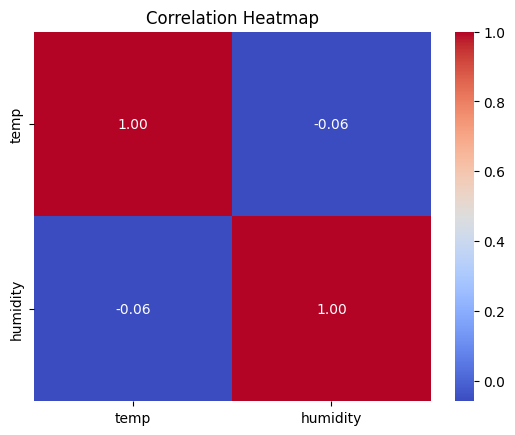

In [ ]:
#create heatmap of correlation
sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.title("Correlation Heatmap")
plt.show()

The correlation heatmap of humidity and temperature shows a very weak negative correlation of -0.06. The correlation is very close to 0, and thus suggests that there is little to no linear relationship between humidity and temperature in the dataset.

# Machine Learning Modeling

Due to the weak relationship between humidity and temperature in the dataset, the models will predict temperature and humidity independently based on historical data. The Random Forest model was used because it effectively captures the patterns in Valencia's temperature data. However, there were some inconsistencies with the humidity data.

**Data Preprocessing**

In [ ]:
#load dataset
vc_df = pd.read_csv('valencia_weather_10_years_clean.csv', parse_dates = ['datetime'])
#create lag features for temp
vc_df['temp_lag1'] = vc_df['temp'].shift(1)
vc_df = vc_df.dropna()  #drop the first row due to lag missing value
#create features based on time
vc_df['day_of_year'] = vc_df['datetime'].dt.dayofyear
vc_df['month'] = vc_df['datetime'].dt.month

#create lag features for humidity
vc_df['humidity_lag1'] = vc_df['humidity'].shift(1)
vc_df = vc_df.dropna() #drop the first row due to lag missing value

**Prepare for Temperature Training**

In [ ]:
#define features and target
X_temp = vc_df[['temp_lag1', 'day_of_year', 'month']]
y_temp = vc_df['temp']
X_humidity = vc_df[['humidity_lag1', 'day_of_year', 'month']]
y_humidity = vc_df['humidity']

#split into training and testing sets
X_train_temp, X_test_temp, y_train_temp, y_test_temp = train_test_split(X_temp, y_temp, test_size = 0.2, random_state = 42)
X_train_humidity, X_test_humidity, y_train_humidity, y_test_humidity = train_test_split(X_humidity, y_humidity, test_size = 0.2, random_state = 42)

**Random Forest Model**

In [ ]:
#initialize and train model
rf_temp = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_temp.fit(X_train_temp, y_train_temp)
rf_humidity = RandomForestRegressor(n_estimators = 100, random_state = 42)
rf_humidity.fit(X_train_humidity, y_train_humidity)

#make predictions
y_pred_temp = rf_temp.predict(X_test_temp)
y_pred_humidity = rf_humidity.predict(X_test_humidity)

#evaluate model
mae_temp = mean_absolute_error(y_test_temp, y_pred_temp)
rmse_temp = mean_squared_error(y_test_temp, y_pred_temp, squared = False)
r2_temp = r2_score(y_test_temp, y_pred_temp)
mae_humidity = mean_absolute_error(y_test_humidity, y_pred_humidity)
rmse_humidity = mean_squared_error(y_test_humidity, y_pred_humidity, squared = False)
r2_humidity = r2_score(y_test_humidity, y_pred_humidity)

print(f'Temperature - MAE: {mae_temp}, RMSE: {rmse_temp}, R²: {r2_temp}')
print(f'Humidity - MAE: {mae_humidity}, RMSE: {rmse_humidity}, R²: {r2_humidity}')

Temperature - MAE: 1.3124142294479977, RMSE: 1.7930383838595407, R²: 0.9095814997289923
Humidity - MAE: 7.755460477375028, RMSE: 10.156235357920375, R²: 0.37986277130033197


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The temperature and humidity predictive models both use lag features. The temperature predictive model uses 'temp_lag1' which represents the temperature from the previous time step, to incorporate temporal dependencies of changes in future predictions. Other features also include 'day_of_year' and 'month' to predict future temperatures. The model has a mean absolute error (MAE) of 1.30, which suggests that the predictive temperature is off from the actual temperature by 1.3 degrees Celcius. Since the error is relatively small, the model performs well. The room mean squared error (RMSE) of 1.78. This indicates that the average prediction error is around 1.78 degrees Celcius, thus the model is a relatively good predictor. The coefficient of determination (R-squared) of 0.91 reveals that the model can explain 91% of the variance in temperature.

The humidity predictive model uses 'humidity_lag1' which represent represents the humidity from the previous time step, to incorporate temporal patterns and improve future humidity predictions. The model has a MAE of 7.72, which suggests that the predictive humidity is off by around 7.72%. This indicates there is a moderate error. The RMSE of 10.11, or average error around 10.11%, points to some errors as well. The R-squared value of 0.39 reveals that the model can explain only 39% of the variance in humidity. Since the R-squared value is low, the model does not effectively capture the factors that influence humidity. Humidity may be influenced by other, more complex factors.

**Actual vs. Predicted Plots for Temperature and Humidity**

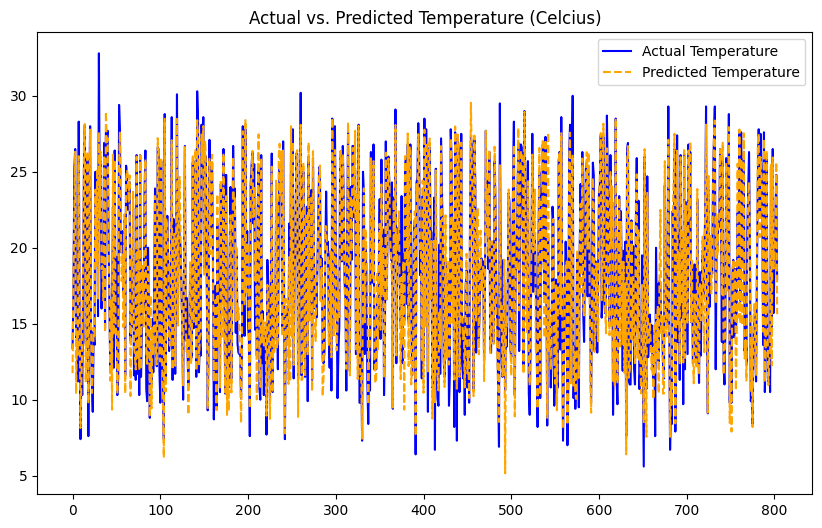

In [ ]:
#actual vs. predicted temperature plot
plt.figure(figsize = (10, 6))
plt.plot(y_test_temp.values, label = 'Actual Temperature', color = 'blue')
plt.plot(y_pred_temp, label = 'Predicted Temperature', color = 'orange', linestyle = '--')
plt.title('Actual vs. Predicted Temperature (Celcius)')
plt.legend()
plt.show()

In the actual vs. predicted temperature plot, the blue line represents the actual temperature and the orange, dashed line represents predicted temperature. It seems like for the most part, the predictive model is a close fit for the actual data. The orange, dashed line closely follows the blue line. There are, however, some points where there are large gaps between the actual and predicted values.

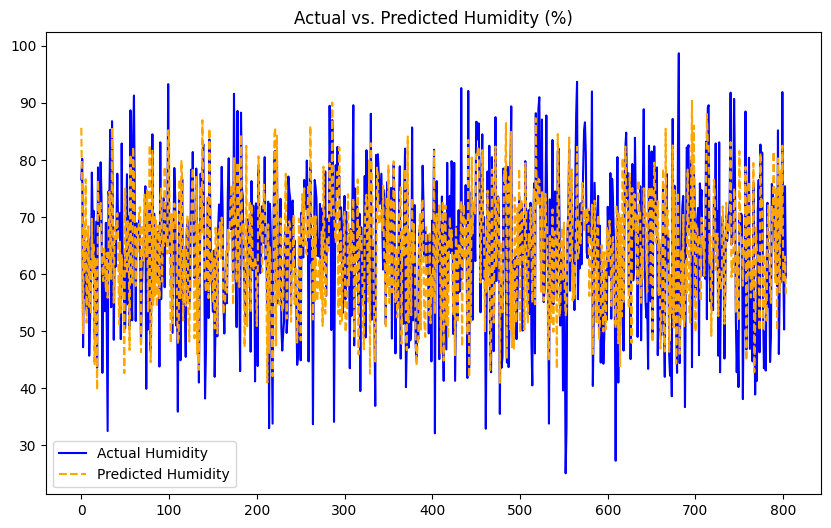

In [ ]:
#actual vs. predicted humidity plot
plt.figure(figsize = (10, 6))
plt.plot(y_test_humidity.values, label = 'Actual Humidity', color = 'blue')
plt.plot(y_pred_humidity, label = 'Predicted Humidity', color = 'orange', linestyle = '--')
plt.title('Actual vs. Predicted Humidity (%)')
plt.legend()
plt.show()

In the actual vs. predicted humidity plot, the blue line represents the actual humidity and the orange, dashed line represents predicted humidity. The predicted line does not seem to be closely following the actual humidity line. This suggests that there are some inconsistencies between the predictive and actual models. The predictive model does not accurately represent the actual model.

# Conclusion

The original objective of the project was to examine precipitation levels and other factors that may have caused the October 2024 floodings in Valencia and other closeby regions. The focus shifted to analyzing seasonal weather trends, such as temperature and humidity levels, over the past decade. The outcomes are then used to create predictive models for temperature and humidity, which can be used for daily weather forecasts and climate variability.

The key findings with seasoning trends are that there are clear seasonal patterns with higher temperatures in the summer and lower temperatures in the winter. The outliers are limited suggesting that the weather trends have been relatively stable over the past decade. For humidity, the seasonal variation is less pronounced than the temperature. There seems to be a slight tendency for higher humidity during the cooler months.

As for predictive modeling, the temperature model showed high accuracy with metrics of 1.30 degrees Celcius for MAE, 1.78 degrees Celcius for RMSE, and 0.91 for R-squared. This suggests that temperature is highly predictable using features like the day of the year and lagged temperature values. These features were the most influential features. The humidity model suggests moderate to low accuracy with metrics of 7.71% for MAE, 10.11% for RMSE, and 39% for R-squared. It is likely that humidity is influenced by other factors not included in the dataset, such as wind speed and atmospheric pressure. Overall, the temperature trends tend to rely on strong and predictable seasonal cycles whereas humidity trends seem to depend on other factors.

There were some challenges and limitations that arose in this project. Mainly, the precipitation data from the Visual Crossing API significantly underreported the precipitation levels in Valencia. Even after reading through the API documents and descriptions, there were discrepancies with the precipitation data. To overcome this, I had initially used other API's with precipitation data on Valencia. However, all of these sources used data from the same weather station at Valencia, so all if these data underreported precipitation levels. After scavenging through many API and databases, I decided to focus on other weather patterns like temperature and humidity. Additionally, ther were some limitations with the random forest model used to predict humidity.


For future projects, incorporating more granular data or potentially using a time-series model may be suggested to better capture and predict weather trends in Valencia. Ultimately, this project highlights the importance of APIs sourcing data from multiple weather platforms. Additionally, it is crucial to understand the dynamics and evolutions of weather patterns in light of climate change. Other potential extensions of similar projects can include how the change in weather impacts importance sectors like agriculture or tourism.

# Reference

AP News. “Spain’s Catastrophic Floods by the Numbers: At Least 219 Dead, 93 Missing and Billions in Damage,” November 7, 2024. https://apnews.com/article/spain-floods-valencia-numbers-21fccd4a9eba4fada0745db0a5a0dd12.

Finch, Walter. “IN PICTURES: Remembering Spain’s Most Catastrophic Floods as This Week’s Valencia Disaster Goes down in History.” Olive Press News Spain (blog), November 2, 2024. https://www.theolivepress.es/spain-news/2024/11/02/in-pictures-astonishing-images-of-past-flooding-disasters-and-the-havoc-they-wrought-on-spain-going-all-the-way-back-to-the-19th-century/.

Papagiannaki, Katerina, Vassiliki Kotroni, Kostas Lagouvardos, Antonis Bezes, Vasileios Vafeiadis, Ioanna Messini, Efstathios Kroustallis, and Ioannis Totos. “Identification of Rainfall Thresholds Likely to Trigger Flood Damages across a Mediterranean Region, Based on Insurance Data and Rainfall Observations.” Water 14, no. 6 (January 2022): 994. https://doi.org/10.3390/w14060994.

“Valencia Climate: Weather Valencia & Temperature by Month.” Accessed December 14, 2024. https://en.climate-data.org/europe/spain/valencian-community/valencia-845/.

“Weather Data Services | Visual Crossing.” Accessed December 14, 2024. https://www.visualcrossing.com/weather/weather-data-services/comunidad%20valenciana?v=api.

